In [22]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [23]:
# Define the UNet model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=64):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, self.crop(enc4, dec4)), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, self.crop(enc3, dec3)), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, self.crop(enc2, dec2)), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, self.crop(enc1, dec1)), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )
        
    def crop(self, enc, dec):
        _, _, H, W = dec.size()
        enc = F.interpolate(enc, size=(H, W), mode='bilinear', align_corners=False)
        return enc

In [24]:
# Load the trained model
model = UNet(in_channels=3, out_channels=1, init_features=32)
model.load_state_dict(torch.load('unet_skin_cancer.pth'))
model.eval()  # Set the model to evaluation mode

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

C:\Users\Kah\AppData\Local\Temp\ipykernel_21796\152712115.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unet_skin_cancer.pth'))


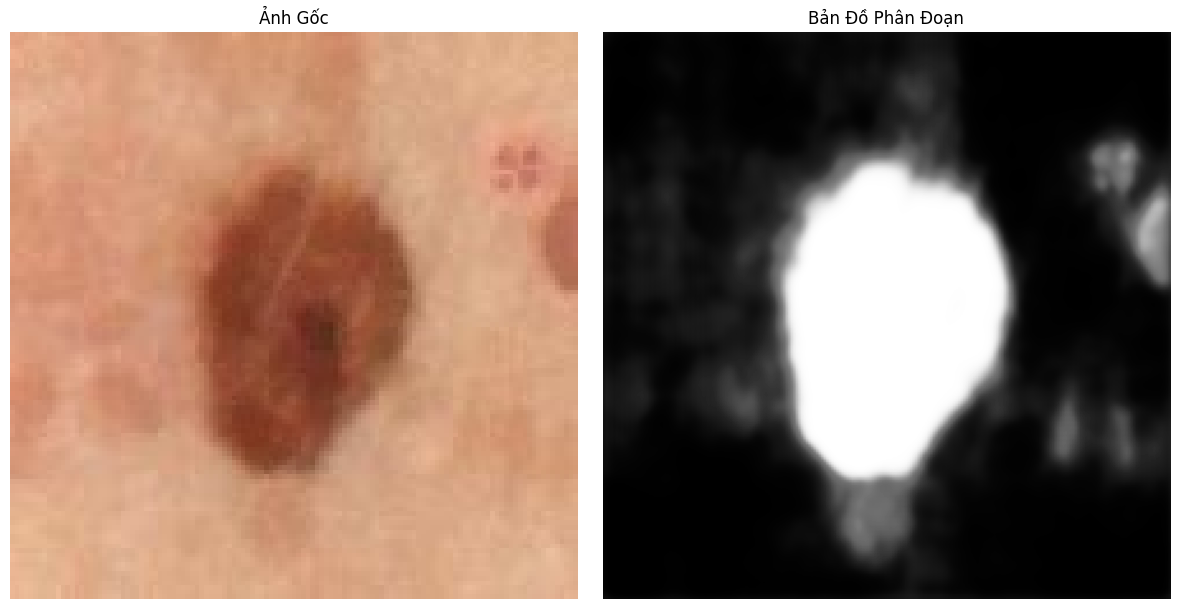

In [25]:
# Load and preprocess the image
img_path = r"D:\SkinCancerPrediction\Preprocessed\HairRemoved\ISIC_0078799.jpg"
original_image = Image.open(img_path).convert("RGB")
image = transform(original_image).unsqueeze(0)  # Add batch dimension

# Move the image to the CPU
device = torch.device('cpu')
image = image.to(device)

# Make prediction
with torch.no_grad():
    model.to(device)
    output = model(image)

# Post-process the output
output = output.squeeze().cpu().numpy()  # Remove batch and channel dimensions

# Hiển thị ảnh gốc và bản đồ phân đoạn song song
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Hiển thị ảnh gốc
axes[0].imshow(original_image)
axes[0].set_title('Ảnh Gốc')
axes[0].axis('off')

# Hiển thị bản đồ phân đoạn
axes[1].imshow(output, cmap='gray')
axes[1].set_title('Bản Đồ Phân Đoạn')
axes[1].axis('off')

plt.tight_layout()
plt.show()

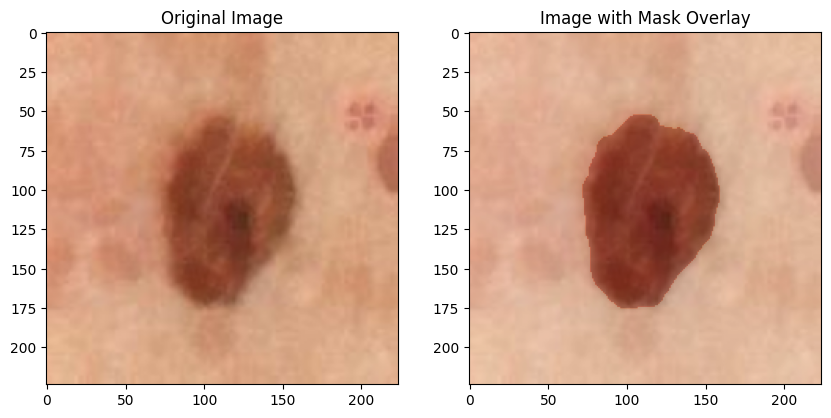

In [26]:
import matplotlib.pyplot as plt
import numpy as np

mask = output
seperated_point = 0.8
mask[output <= seperated_point] = 0  # Set values <= 0.5 to 0
mask[output > seperated_point] = 1   # Set values > 0.5 to 1
    
original_image_zoomed = original_image.resize((224,224))
image_np = np.array(original_image_zoomed) / 255.0
    
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(image_np)
plt.imshow(mask, cmap='Reds', alpha=0.2)
plt.title("Image with Mask Overlay")
plt.show()
